<a href="https://colab.research.google.com/github/211FA04602/211FA04602/blob/main/Leaf_Disease_Prediction_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:



import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'leaf-image-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1951218%2F3217030%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240228%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240228T062418Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da7d63474a1757d59dfb8b7c4ca7fb7409738ab0ca7f4627441e60c8dce350b90aef7881cebeaac7b252bf81d5a8cb5e2d03090c7b12564b972753571130d2eb9689e7db0e2c09d993cb8e0dda005ee641154a857a468bdcc89bdf5710f454847d2bd67f88ada7f60a66ed467ff34cfa4d3479bbe317adbbd2da9e82214d144f79c971c3f7447b7d88537e38be069d3ba7307d58c464dd60ec3578cc05b8e3c8104d4f979973c40bc2fcbbc2fe108f927bf45c91f11c4eb590036e94c8aa7e947b9230c37804c972de5f9a1129310c4f4854ef5c8bd74429f76d695f94b3717614fdd65c9c6380aa7571e0a6694e0d8f8769505d97a101b7d627fc5c8d2ea2138'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 14105730 bytes downloaded
Downloaded and uncompressed: leaf-image-dataset
Data source import complete.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random
import os
from os import listdir
from PIL import Image
from sklearn.preprocessing import label_binarize,  LabelBinarizer
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from tensorflow.keras.utils import to_categorical


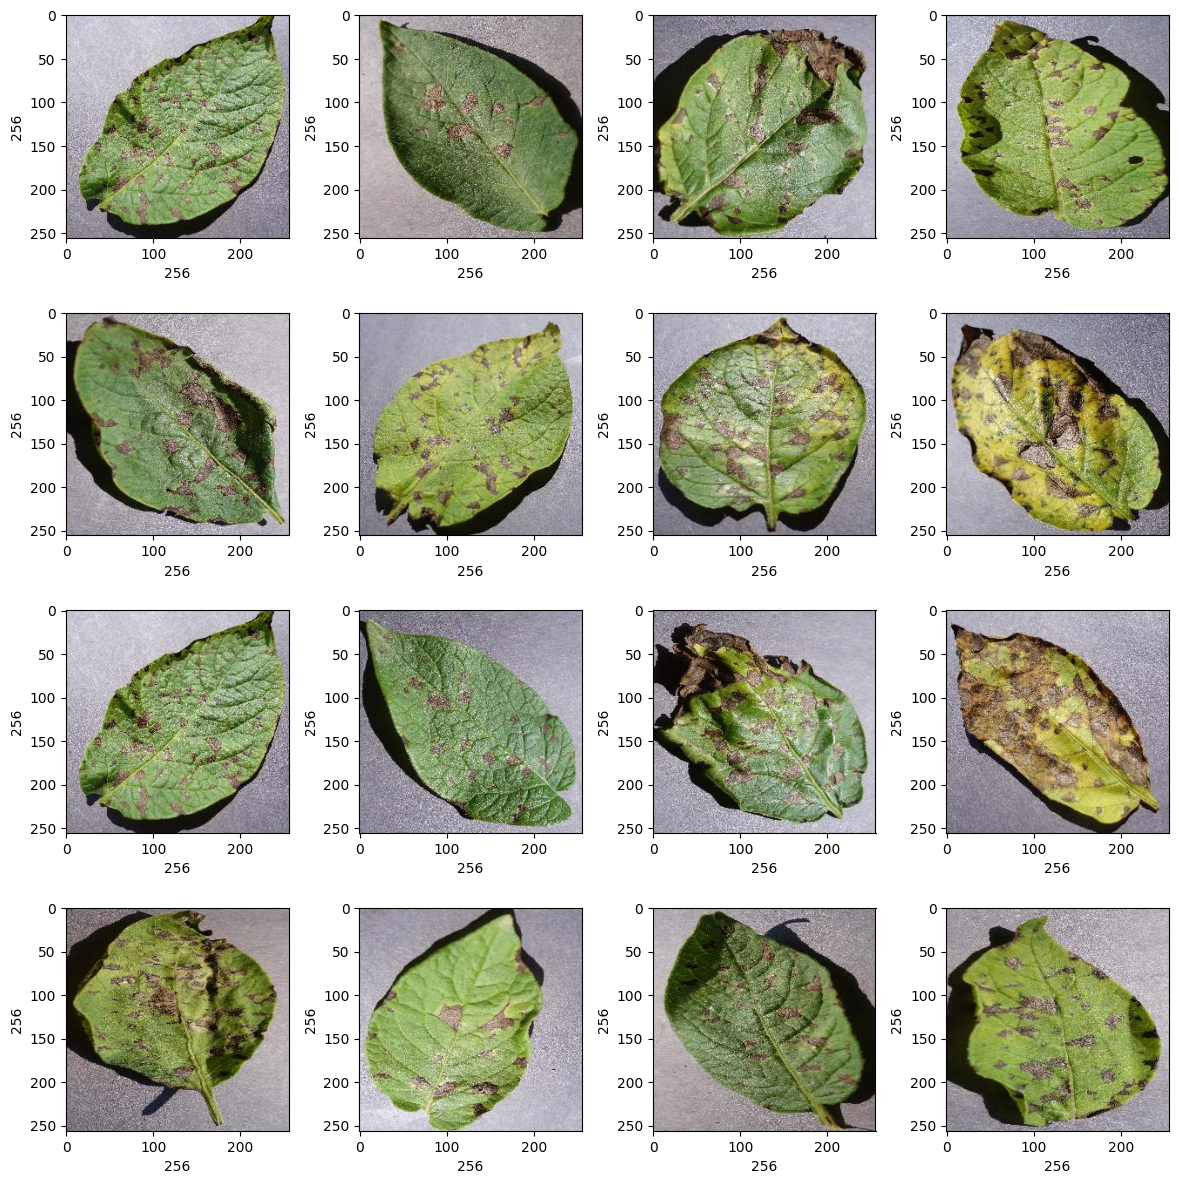

In [36]:

plt.figure(figsize=(12,12))
path = "../input/leaf-image-dataset/Plant_images/Potato___Early_blight"
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10)
    plt.ylabel(rand_img.shape[0], fontsize = 10)

In [4]:

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, (256,256))

            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [5]:
dir = "../input/leaf-image-dataset/Plant_images"
root_dir = listdir(dir)
image_list, label_list = [], []
all_labels = ['Corn-Common_rust', 'Potato-Early_blight', 'Tomato-Bacterial_spot']
binary_labels = [0,1,2]
temp = -1

for directory in root_dir:
  plant_image_list = listdir(f"{dir}/{directory}")
  temp += 1
  for files in plant_image_list:
    image_path = f"{dir}/{directory}/{files}"
    image_list.append(convert_image_to_array(image_path))
    label_list.append(binary_labels[temp])



In [6]:

label_counts = pd.DataFrame(label_list).value_counts()
label_counts.head()


0    300
1    300
2    300
dtype: int64

In [7]:

image_list[0].shape

(256, 256, 3)

In [8]:

label_list = np.array(label_list)
label_list.shape

(900,)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(image_list, label_list, test_size=0.2, random_state = 10)

In [10]:

x_train = np.array(x_train, dtype=np.float16) / 225.0
x_test = np.array(x_test, dtype=np.float16) / 225.0
x_train = x_train.reshape( -1, 256,256,3)
x_test = x_test.reshape( -1, 256,256,3)

In [11]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [12]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding="same",input_shape=(256,256,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(16, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(8, activation="relu"))
model.add(Dense(3, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 85, 85, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 42, 42, 16)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 28224)             0         
                                                                 
 dense (Dense)               (None, 8)                 2


While compiling the model we need to set the type of loss which will be Binary Crossentropy for our model alongwith this we also need to set the optimizer and the metrics respectively.

In [13]:
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001),metrics=['accuracy'])

In [14]:

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)

In [15]:

epochs = 50
batch_size = 128
history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs,
                    validation_data = (x_val, y_val))

Epoch 1/50
5/5 [==============================] - 42s 9s/step - loss: 1.1095 - accuracy: 0.2951 - val_loss: 1.0694 - val_accuracy: 0.3333
Epoch 2/50
5/5 [==============================] - 34s 7s/step - loss: 1.0418 - accuracy: 0.3351 - val_loss: 1.0202 - val_accuracy: 0.3403
Epoch 3/50
5/5 [==============================] - 30s 6s/step - loss: 1.0170 - accuracy: 0.4653 - val_loss: 0.9922 - val_accuracy: 0.5833
Epoch 4/50
5/5 [==============================] - 33s 7s/step - loss: 0.9851 - accuracy: 0.5521 - val_loss: 0.9560 - val_accuracy: 0.5278
Epoch 5/50
5/5 [==============================] - 30s 6s/step - loss: 0.9472 - accuracy: 0.5069 - val_loss: 0.9242 - val_accuracy: 0.5000
Epoch 6/50
5/5 [==============================] - 33s 7s/step - loss: 0.9159 - accuracy: 0.5347 - val_loss: 0.8856 - val_accuracy: 0.6042
Epoch 7/50
5/5 [==============================] - 31s 6s/step - loss: 0.8805 - accuracy: 0.6024 - val_loss: 0.8507 - val_accuracy: 0.6250
Epoch 8/50
5/5 [==================

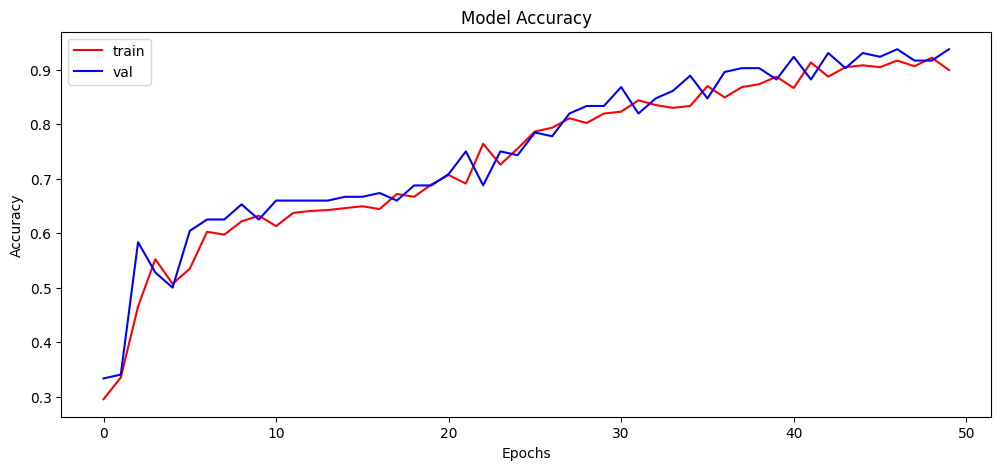

In [16]:

plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

In [17]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
6/6 [==============================] - 3s 534ms/step - loss: 0.3814 - accuracy: 0.8944
Test Accuracy: 89.4444465637207


In [18]:
y_pred = model.predict(x_test)

6/6 [==============================] - 3s 448ms/step


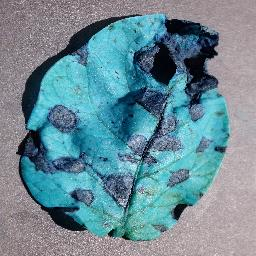

In [30]:

img = array_to_img(x_test[9])
img

In [34]:

print("Originally : ",all_labels[np.argmax(y_test[10])])
print("Predicted : ",all_labels[np.argmax(y_pred[10])])

Originally :  Potato-Early_blight
Predicted :  Potato-Early_blight
